In [1]:
import rooms.dataset
import render
import torch
import torch.nn as nn
import metrics
import train
import os

/home/gzanin/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
torch.set_default_dtype(torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_name = "prova"

D = rooms.dataset.dataLoader(dataset_name)

In [4]:
#training parameters

n_fibonacci = 128 #128 #128 nel test
late_stage_model= "UniformResidual" #"UniformResidual"
toa_perturb = True #True
model_transmission = False #False

skip_train = False #False
continue_train = False #False

n_epochs = 100 #1000 
batch_size = 4 #4 #4 nel test
lr = 1e-2 #1e-2
pink_noise_supervision = False #True
pink_start_epoch = 500 #500
fs = 48000 #48000 #48000 nel test

load_dir= None
save_dir= '~/prova_training_1000epochs'

In [5]:
R = render.Renderer(n_surfaces=len(D.all_surfaces), n_fibonacci=n_fibonacci,
                        late_stage_model=late_stage_model,
                        toa_perturb = toa_perturb, model_transmission=model_transmission).to(device)

In [6]:
# Utilizza più GPU se disponibili
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    R = nn.DataParallel(R).module

solo per training le prossime

In [7]:
#directional case
loss_fcn = metrics.training_loss_directional

for listener_position in D.RIRs:
    for response in listener_position:
        response['t_response'] = torch.Tensor(response['t_response'][:R.RIR_length])
        response['t_response'].to(device) 

gt_audio = D.RIRs
rendering_method = render.Renderer.render_RIR_directional

In [8]:
def initialize(indices, source_xyz, listener_xyzs, surfaces, load_dir):
    Ls = []

    for idx in indices:
        L= render.get_listener(source_xyz=source_xyz, listener_xyz = listener_xyzs[idx], surfaces = surfaces, 
                               load_dir = load_dir, load_num = idx, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order)
        Ls.append(L)
    return Ls

In [ ]:
"""
Training
"""
if not skip_train:
    print("Training")

    #Initialize Listeners
    Ls = initialize(indices=D.train_indices,
                    listener_xyzs=D.xyzs,
                    source_xyz=D.speaker_xyz,
                    surfaces=D.all_surfaces,
                    load_dir=load_dir)
            
    if continue_train:
        R.load_state_dict(torch.load(os.path.join(save_dir,"weights.pt"))['model_state_dict'])

    losses = train.train_loop(R=R, Ls=Ls, train_gt_audio=gt_audio[D.train_indices], D=D,
                        n_epochs = n_epochs, batch_size = batch_size, lr = lr, loss_fcn = loss_fcn,
                        save_dir=save_dir,
                        pink_noise_supervision = pink_noise_supervision,
                        pink_start_epoch=pink_start_epoch,
                        continue_train = continue_train, fs=fs)

else:
    R.load_state_dict(torch.load(os.path.join(save_dir,"weights.pt"))['model_state_dict'])
    R.train = False
    R.toa_perturb = False

prova di ascolto

In [7]:
import numpy as np
import evaluate

In [8]:
pt_file = torch.load(save_dir + '/weights.pt', map_location=device)
R.energy_vector = nn.Parameter(pt_file['model_state_dict']['energy_vector'])
R.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

R.bp_ord_cut_freqs = nn.Parameter(pt_file['model_state_dict']['bp_ord_cut_freqs'])

In [9]:
listener_1 = render.get_listener(source_xyz= np.array([5,3,1.5]), listener_xyz = np.array([5,7,1.5]), surfaces = D.all_surfaces, 
                               load_dir = load_dir, load_num = None, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order)

listener_2 = render.get_listener(source_xyz= np.array([9.9,9.9,2.9]), listener_xyz = np.array([5,3,1.5]), surfaces = D.all_surfaces, 
                               load_dir = load_dir, load_num = None, speed_of_sound = D.speed_of_sound, 
                               max_order = D.max_order, parallel_surface_pairs = D.parallel_surface_pairs, 
                               max_axial_order = D.max_axial_order)

Considered Paths:	7776
Total Considered Paths, after Axial:	7806
Valid Paths:	831
Considered Paths:	7776
Total Considered Paths, after Axial:	7806
Valid Paths:	703


In [10]:
RIR_1 = R.render_RIR(listener_1)

In [11]:
RIR_2 = R.render_RIR(listener_2)

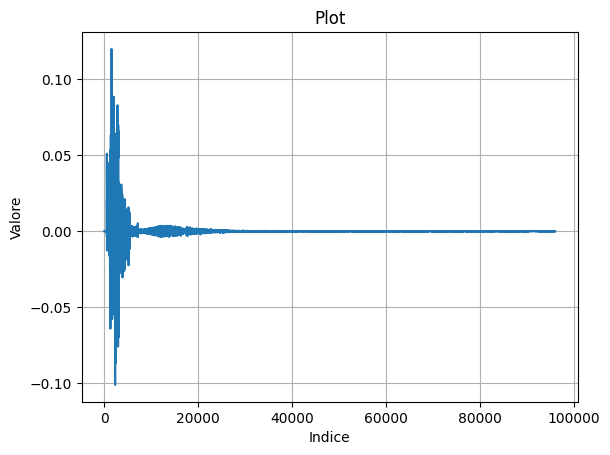

In [34]:
import torch
import matplotlib.pyplot as plt

# Step 3: Fare il plot del tensore
plt.plot(RIR_1.detach().cpu())
plt.title("Plot")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.grid(True)
plt.show()

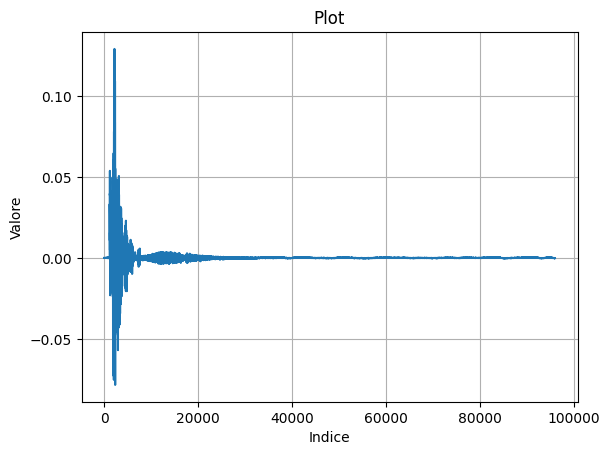

In [35]:
import torch
import matplotlib.pyplot as plt

# Step 3: Fare il plot del tensore
plt.plot(RIR_2.detach().cpu())
plt.title("Plot")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.grid(True)
plt.show()

In [12]:
predicted_music_1 = evaluate.render_music(np.array([RIR_1.detach().cpu()]), np.array([D.music_dls[0]]), device = device)
predicted_music_2 = evaluate.render_music(np.array([RIR_2.detach().cpu()]), np.array([D.music_dls[0]]), device = device)

In [13]:
import sounddevice as sd

duration = predicted_music_1.shape[2]/fs  # Durata in secondi
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


sd.play(predicted_music_1[0][0], samplerate=48000)
sd.wait()  # Aspetta che la riproduzione termini


In [14]:
duration = predicted_music_2.shape[2]/fs  # Durata in secondi
t = np.linspace(0, duration, int(fs * duration), endpoint=False)


sd.play(predicted_music_2[0][0], samplerate=48000)
sd.wait()  # Aspetta che la riproduzione termini

In [16]:
sd.play(D.music_dls[9][0], samplerate=48000)
sd.wait()  # Aspetta che la riproduzione termini